In [1]:
import os
import torch
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import time

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import scipy
import torch
from torch.utils.data import DataLoader

os.chdir('..')
from data_processing.datasets import MouseDataset
from neuralnet.model import SpectraMLP
import data_processing.preprocessing as preprocessing
from torch.utils.data import ConcatDataset
import utils

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
path = "dataset/simulated-Piglet-Data/"
folder = os.listdir(path)
folder = [i for i in folder if i != '.DS_Store']
dic = {}
for i in folder:    
    files = os.listdir(path+i)
    files = [i for i in files if ".mat" in i]
    if files == []: continue
    dic[i] = files

dic.keys()

dict_keys(['185_185_121_1', '185_185_121_2'])

In [3]:
# Testing 185_2 data
img = scipy.io.loadmat('./dataset/simulated-Piglet-Data/185_185_121_1/PPLvessel_baseline.mat')
arr_0 = img['ppl_2']
print(np.any(arr_0 <= 0))

True


### Data preprocessing

Prepare training and test dataset similar in form to that of piglet_diff that will be feed into the neural network. However, the spectra value is measured in the spatial domain instead of time domain. We have a spatial dimension of (185,185) with 121 wavelength in the range of 780-900nm.

In [4]:
# Define config
wavelenghts_121 = np.linspace(780, 900, 121)
left_cut = 779
right_cut = 901

In [5]:
def optimisation(spectr1, spectr2, wavelengths):
    m = 4  # number of parameters (from 2 to 6)
    #np.random.seed(1)
    molecules, x = preprocessing.read_molecules(left_cut, right_cut, wavelengths)
    y_hbo2_f, y_hb_f, y_coxa, y_creda, _, _ = molecules
    M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                                np.asarray(y_hb_f),
                                np.asarray(y_coxa),
                                np.asarray(y_creda))))
    
    b = spectr2 / spectr1
    b = np.log(1 / np.asarray(b))  # see the writting above (we took log of I_R and there was also minus that went to the degree of the logarithm)
    X = cp.Variable((m, len(b)))
    b = np.swapaxes(b, 0, 1)
    
    print(M.shape, X.shape, b.shape)
     
    objective = cp.Minimize(cp.sum_squares(M @ X - b))
    constraints = [cp.abs(X[2]+X[3])<=0.01]
    prob = cp.Problem(objective, constraints)
    
    start = time.time()
    result = prob.solve()
    print("Time:", time.time() - start)

    return -X.value, b


In [6]:
search_keys = ['ppl_2', 'ppl_1', 'ppl', 'hypercube']
    
for pig in dic.keys():
    for index, date in enumerate(dic[pig]):  
        print(pig, date)
        img = scipy.io.loadmat(path+ pig + '/' + date)
        wavelengths = wavelenghts_121
        matching_keys = [key for key in img.keys() if any(search_key in key for search_key in search_keys)][0]
        spectr = img[matching_keys]
        size_x, size_y, channel = spectr.shape
        
        spectr[spectr <= 0] = 0.0001
        spectr = spectr.reshape((-1, spectr.shape[-1]))
        
        ref_spect = np.expand_dims(spectr[:,0], axis=1)

        coef_diff, spect_diff = optimisation(ref_spect, spectr, wavelengths)
        coef_diff = np.reshape(coef_diff, (4,size_x,size_y)).T
        spect_diff = np.reshape(spect_diff, (channel,size_x,size_y)).T
        
        coef_diff = torch.from_numpy(coef_diff)
        spect_diff = torch.from_numpy(spect_diff)
        
        # Tomorrow torch.save in location piglet_diff_sim3
        save_folder = str(pig)+'_'+str(index)
        utils.save_optimization_data3(spect_diff, coef_diff, save_folder)
        
        # spectra_list.append(spect_diff)
        # coef_list.append(coef_diff)
         
        

185_185_121_1 PPLvessel_baseline.mat
(121, 4) (4, 34225) (121, 34225)
Time: 55.265562772750854
185_185_121_1 PPLgrey_hypoxia.mat
(121, 4) (4, 34225) (121, 34225)
Time: 52.89966917037964
185_185_121_1 PPLvessel_hypoxia.mat
(121, 4) (4, 34225) (121, 34225)
Time: 54.99255108833313
185_185_121_1 PPLtot_baseline.mat
(121, 4) (4, 34225) (121, 34225)
Time: 52.083264112472534
185_185_121_1 PPLtot_hypoxia.mat
(121, 4) (4, 34225) (121, 34225)
Time: 50.865659952163696
185_185_121_1 PPLgrey_baseline.mat
(121, 4) (4, 34225) (121, 34225)
Time: 53.48125386238098
185_185_121_1 hypercube_baseline.mat
(121, 4) (4, 34225) (121, 34225)
Time: 50.86446404457092
185_185_121_1 hypercube_hypoxia.mat
(121, 4) (4, 34225) (121, 34225)
Time: 52.21669888496399
185_185_121_2 PPL_wgth_baseline.mat
(121, 4) (4, 34225) (121, 34225)
Time: 46.744725942611694
185_185_121_2 hypercube_baseline.mat
(121, 4) (4, 34225) (121, 34225)
Time: 54.092609882354736
185_185_121_2 PPL_1_wgth_baseline.mat
(121, 4) (4, 34225) (121, 34225)

In [130]:
specttest = "./dataset/mouse_diffs/185_185_121_1_2/spectra.pt"
coefftest = "./dataset/mouse_diffs/185_185_121_1_2/coef.pt"
with open(specttest, 'rb') as spectra_file:
    spectra_file = torch.load(spectra_file) 
with open(coefftest, 'rb') as params_file:
    params_file = torch.load(params_file )            

In [131]:
params_file.shape

torch.Size([185, 185, 4])

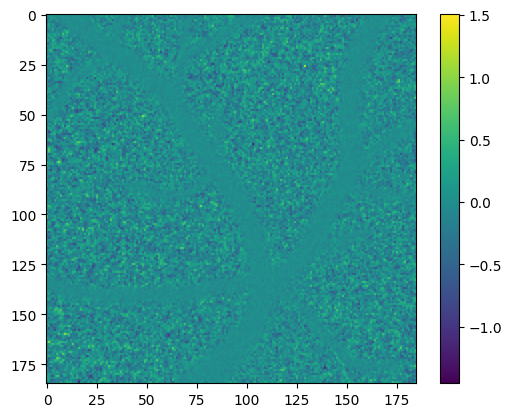

In [132]:
coeff_map = params_file.detach().cpu().numpy()
map0 = coeff_map[:,:,0]
# map0[map0<=0]=0
plt.imshow(map0, cmap="viridis")
colorbar = plt.colorbar()
plt.show()

### Training

Train the model using the spectra concentration pair

In [3]:
from train_mouse import train_mouse

/Users/boeykaizhe/opt/anaconda3/envs/i2dl/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 1/1000
----------


  0%|                                                     | 0/1 [00:00<?, ?it/s]

output shape:  torch.Size([6, 185, 185, 4])
targets shape:  torch.Size([6, 185, 185, 4])


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.84it/s]


validation loss at epoch 0: 0.027301514521241188
Epoch 2/1000
----------


  0%|                                                     | 0/1 [00:00<?, ?it/s]

output shape:  torch.Size([6, 185, 185, 4])
targets shape:  torch.Size([6, 185, 185, 4])


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]


validation loss at epoch 1: 0.01641453616321087
Epoch 3/1000
----------


  0%|                                                     | 0/1 [00:00<?, ?it/s]

output shape:  torch.Size([6, 185, 185, 4])
targets shape:  torch.Size([6, 185, 185, 4])


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]


validation loss at epoch 2: 0.009093835949897766
Epoch 4/1000
----------


  0%|                                                     | 0/1 [00:00<?, ?it/s]

output shape:  torch.Size([6, 185, 185, 4])
targets shape:  torch.Size([6, 185, 185, 4])


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.81it/s]


validation loss at epoch 3: 0.007326387334614992
Epoch 5/1000
----------


  0%|                                                     | 0/1 [00:00<?, ?it/s]

output shape:  torch.Size([6, 185, 185, 4])
targets shape:  torch.Size([6, 185, 185, 4])


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.04it/s]


validation loss at epoch 4: 0.005848478525876999
Epoch 6/1000
----------


  0%|                                                     | 0/1 [00:00<?, ?it/s]

output shape:  torch.Size([6, 185, 185, 4])
targets shape:  torch.Size([6, 185, 185, 4])


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.44it/s]


validation loss at epoch 5: 0.0034973621368408203
Epoch 7/1000
----------


  0%|                                                     | 0/1 [00:00<?, ?it/s]

output shape:  torch.Size([6, 185, 185, 4])
targets shape:  torch.Size([6, 185, 185, 4])


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.27it/s]


validation loss at epoch 6: 0.0029319843742996454
Epoch 8/1000
----------


  0%|                                                     | 0/1 [00:00<?, ?it/s]

output shape:  torch.Size([6, 185, 185, 4])
targets shape:  torch.Size([6, 185, 185, 4])


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]


validation loss at epoch 7: 0.004205594304949045
patience: 1/10
Epoch 9/1000
----------


  0%|                                                     | 0/1 [00:00<?, ?it/s]

output shape:  torch.Size([6, 185, 185, 4])
targets shape:  torch.Size([6, 185, 185, 4])


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.72it/s]


validation loss at epoch 8: 0.004288545809686184
patience: 2/10
Epoch 10/1000
----------


  0%|                                                     | 0/1 [00:00<?, ?it/s]

output shape:  torch.Size([6, 185, 185, 4])
targets shape:  torch.Size([6, 185, 185, 4])


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.50it/s]


validation loss at epoch 9: 0.0033407071605324745
patience: 3/10
Epoch 11/1000
----------


  0%|                                                     | 0/1 [00:00<?, ?it/s]

output shape:  torch.Size([6, 185, 185, 4])
targets shape:  torch.Size([6, 185, 185, 4])


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.37it/s]


validation loss at epoch 10: 0.0026742788031697273
Epoch 12/1000
----------


  0%|                                                     | 0/1 [00:00<?, ?it/s]

output shape:  torch.Size([6, 185, 185, 4])
targets shape:  torch.Size([6, 185, 185, 4])


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.40it/s]


validation loss at epoch 11: 0.002397816628217697
Epoch 13/1000
----------


  0%|                                                     | 0/1 [00:00<?, ?it/s]

output shape:  torch.Size([6, 185, 185, 4])
targets shape:  torch.Size([6, 185, 185, 4])


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.31it/s]


validation loss at epoch 12: 0.002213366562500596
Epoch 14/1000
----------


  0%|                                                     | 0/1 [00:00<?, ?it/s]

output shape:  torch.Size([6, 185, 185, 4])
targets shape:  torch.Size([6, 185, 185, 4])


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.29it/s]


validation loss at epoch 13: 0.0019072842551395297
Epoch 15/1000
----------


  0%|                                                     | 0/1 [00:00<?, ?it/s]

output shape:  torch.Size([6, 185, 185, 4])
targets shape:  torch.Size([6, 185, 185, 4])


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.09it/s]


validation loss at epoch 14: 0.0016250789631158113
Epoch 16/1000
----------


  0%|                                                     | 0/1 [00:00<?, ?it/s]

output shape:  torch.Size([6, 185, 185, 4])
targets shape:  torch.Size([6, 185, 185, 4])


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.64it/s]


validation loss at epoch 15: 0.0017054033232852817
patience: 1/10
Epoch 17/1000
----------


  0%|                                                     | 0/1 [00:00<?, ?it/s]

output shape:  torch.Size([6, 185, 185, 4])
targets shape:  torch.Size([6, 185, 185, 4])


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.46it/s]


validation loss at epoch 16: 0.0020294117275625467
patience: 2/10
Epoch 18/1000
----------


  0%|                                                     | 0/1 [00:00<?, ?it/s]

output shape:  torch.Size([6, 185, 185, 4])
targets shape:  torch.Size([6, 185, 185, 4])


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


validation loss at epoch 17: 0.002090567722916603
patience: 3/10
Epoch 19/1000
----------


  0%|                                                     | 0/1 [00:00<?, ?it/s]

output shape:  torch.Size([6, 185, 185, 4])
targets shape:  torch.Size([6, 185, 185, 4])


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.53it/s]


validation loss at epoch 18: 0.001796963275410235
patience: 4/10
Epoch 20/1000
----------


  0%|                                                     | 0/1 [00:00<?, ?it/s]

output shape:  torch.Size([6, 185, 185, 4])
targets shape:  torch.Size([6, 185, 185, 4])


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.06it/s]


validation loss at epoch 19: 0.0015198910841718316
Training complete in 0m 26s


### Inference

Given we have obtained the best model from the training using the spectra & tissue concentration pair, now we apply the model to infer the test spectra value 

In [99]:
test_data_path = "dataset/mouse_diffs_tests/"
_, dirs, _ = os.walk(test_data_path).__next__()
dirs.remove('.ipynb_checkpoints') if '.ipynb_checkpoints' in dirs else dirs
spectra_datasets = MouseDataset(test_data_path,dirs)
dl = DataLoader(spectra_datasets, batch_size=4, shuffle=False)
spectra, concentration  = next(iter(dl))

model = SpectraMLP(4, n_layers=2, layer_width=256)
checkpoints = torch.load('results_mouse/2_256/best_model.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoints)
model.to(device)
model.eval()
preds = model(spectra.float()).detach().numpy()

pred0 = preds[0,:,:,:]
pred1 = preds[1,:,:,:]
pred2 = preds[2,:,:,:]
pred3 = preds[3,:,:,:]

target0 = concentration[0,:,:,:]
target1 = concentration[1,:,:,:]
target2 = concentration[2,:,:,:]
target3 = concentration[3,:,:,:]

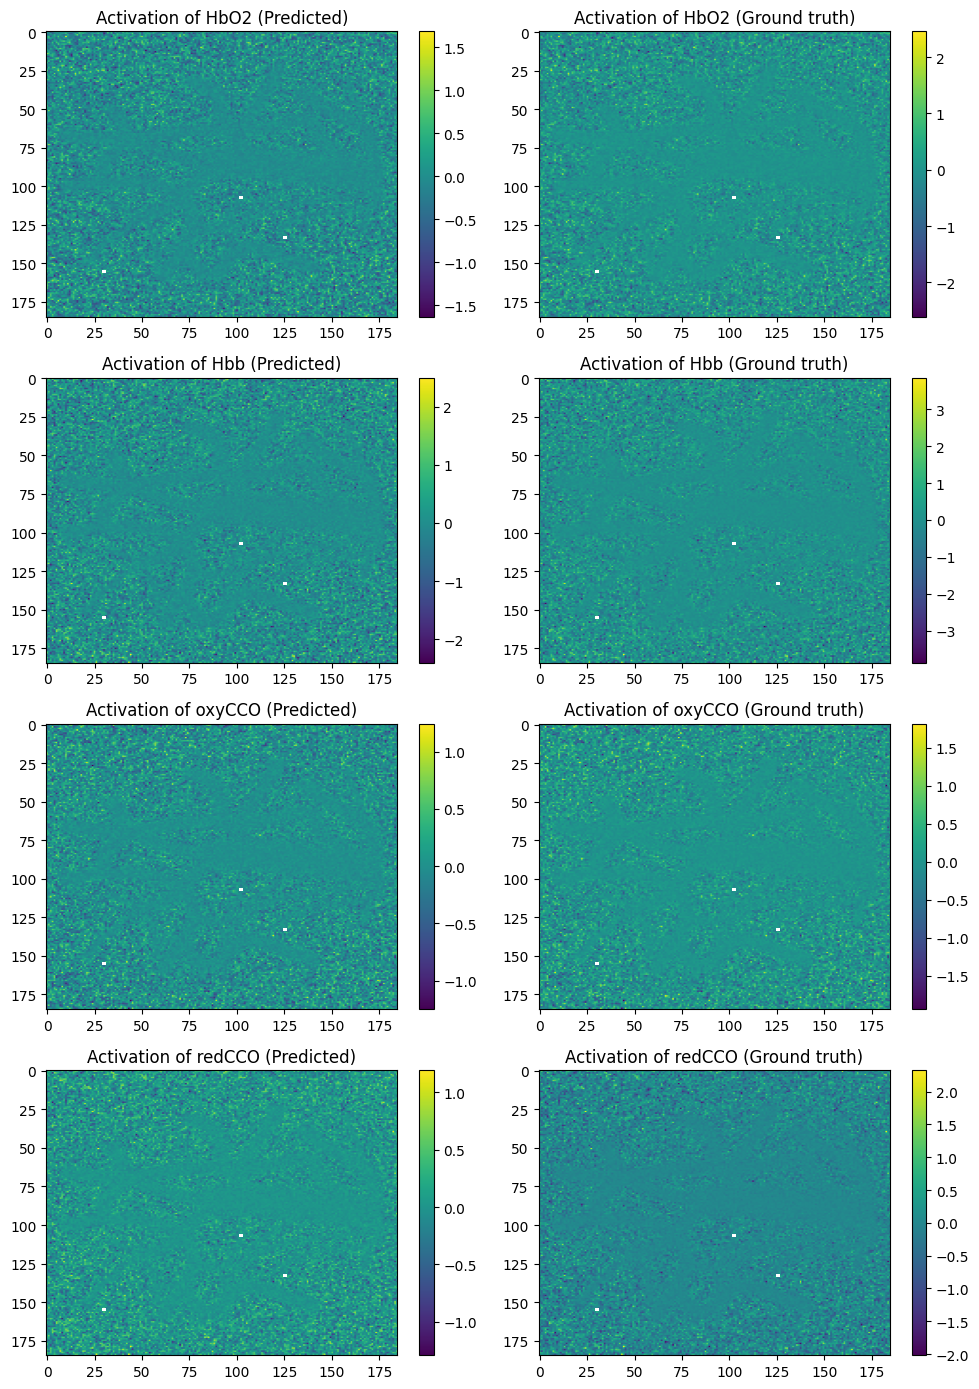

In [156]:
coeff = ["HbO2", "Hbb", "oxyCCO", "redCCO"]

def plot(pred, target):
    fig, axs = plt.subplots(4, 2, figsize=(10, 14))

    # Loop over each row of subplots
    for i in range(4):
        # Plot Predicted
        im_pred = axs[i, 0].imshow(pred[:, :, i], cmap='viridis', aspect='auto')
        axs[i, 0].set_title(f'Activation of {coeff[i]} (Predicted)')
        plt.colorbar(im_pred, ax=axs[i, 0])

        # Plot Actual
        im_actual = axs[i, 1].imshow(target[:, :, i], cmap='viridis', aspect='auto')
        axs[i, 1].set_title(f'Activation of {coeff[i]} (Ground truth)')
        plt.colorbar(im_actual, ax=axs[i, 1])

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plot
    plt.show()
    
plot(pred2, target2)

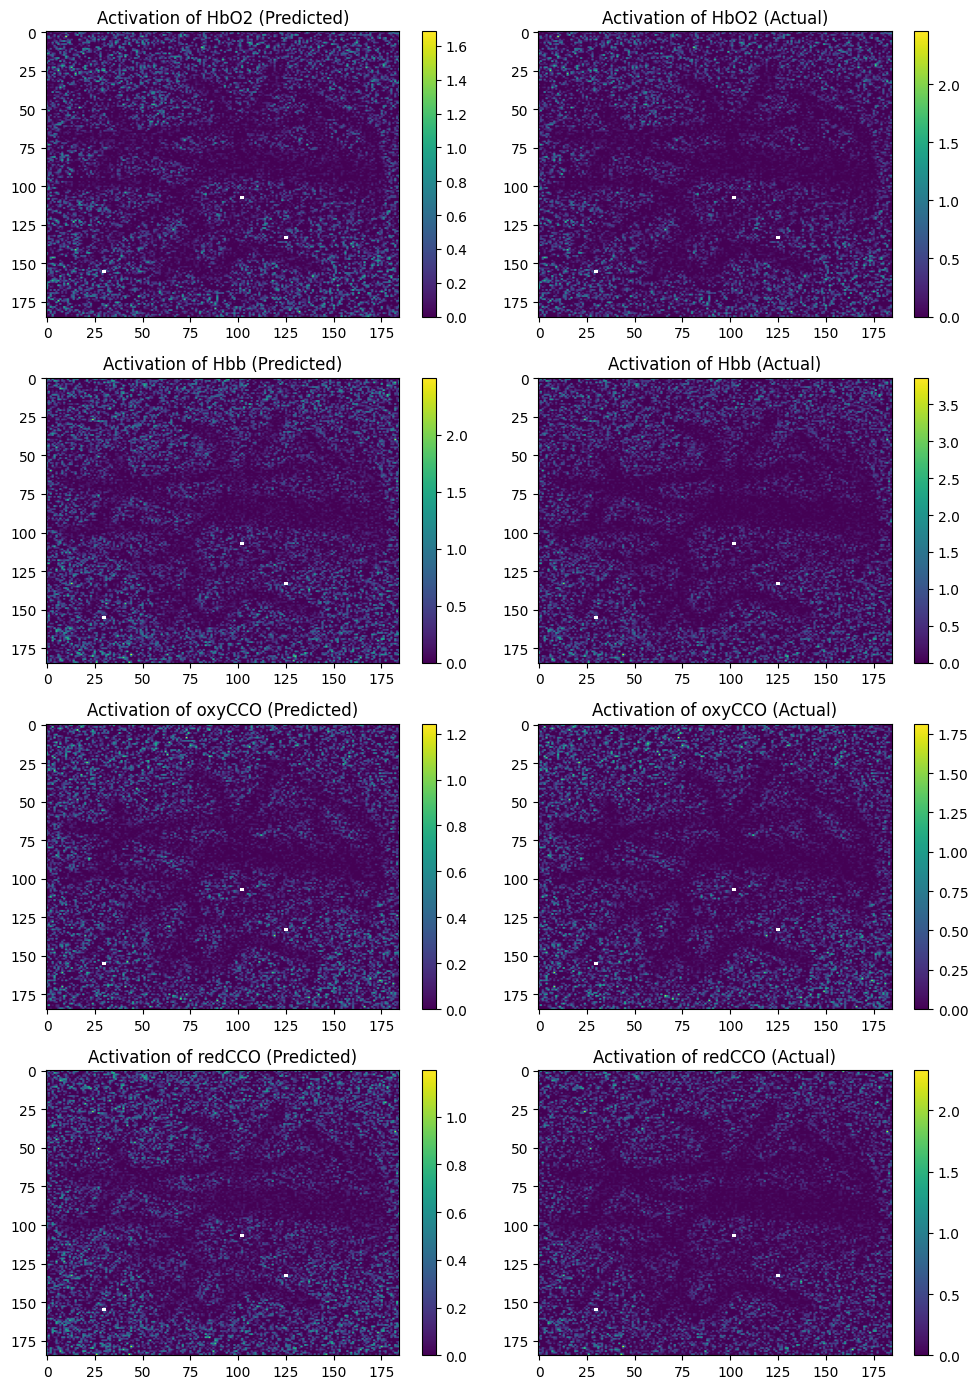

In [147]:
# Looks better if filter out negative value
pred2_filter = np.maximum(pred2, 0)
target2_filter = np.maximum(target2, 0)

plot(pred2_filter, target2_filter)

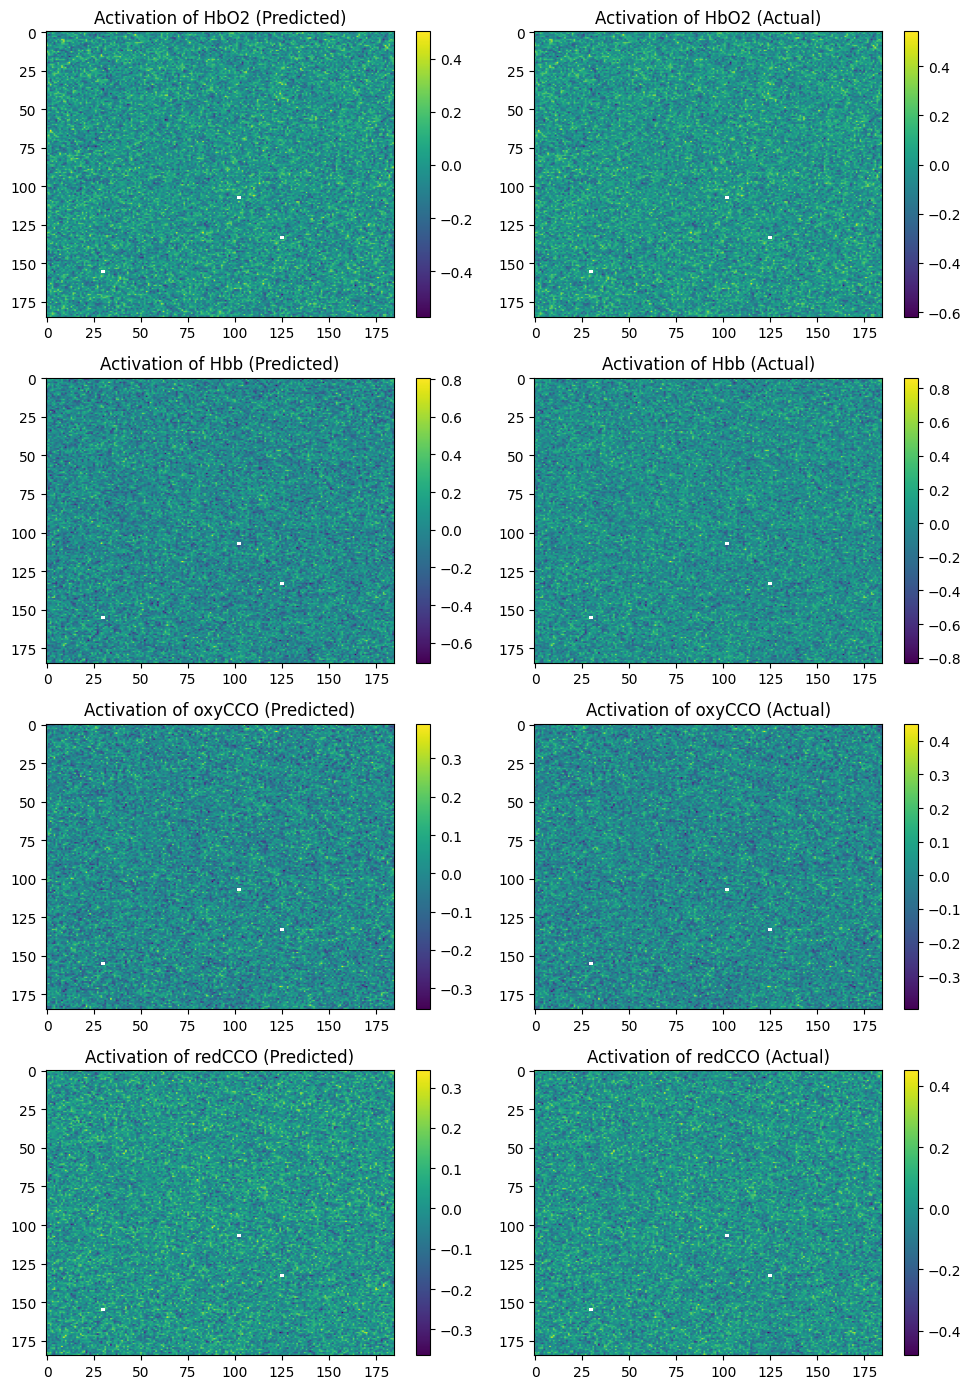

In [146]:
# Some sample are so not too well predicted
plot(pred0, target0)